In [2]:
#Imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

# Constants

In [3]:
class Constants:
    """
    Important Constants for Calculations
        c = Speed of light (m/s)

        Mu0 = permeability of free space in H/m

        MuB = Bohr magneton in J/T

        Epsilon0 = permittivity of free space in F/m

        amu = atomic mass unit in kg

        HBar = reduced planck's constant in Js

        kB = Stegan-Boltzman constant in J/K

        h = planck's constat in Js

        a0 = bohr radius in dm

        g = gravitational acceleration in m/s^2

        Lamdba1064 = 1064nm in m
    """

    #Constants
    c = 2.99792458e8
    Mu0 = 4*np.pi*1e-7
    MuB = 9.2740095e-24
    Epsilon0 = 8.854187e-12
    amu = 1.66053906892e-27
    HBar = 1.054571628e-34
    kB = 1.3806504e-23
    h = 6.62607015e-34
    a0 = 0.52917720859e-10
    g = 9.807 
    
    #Conversions
    Lambda1064 = 1064e-9
    Lambda632 = 632e-9
    Lambda635 = 635e-9


# Atomic Properties

In [4]:
class Cs133:
    """This class stores atomic properties of cesium-133."""
    mass = 132.905451931 * Constants.amu  # atomic mass in kg
    aBB = 277 # Cs-Cs scattering length in bohr radii

    class GS: #ground state
        g_j = 2.002540261 #fine structure landé g-factor
        aHF = Constants.h * 2.2981579425e9 #hyperfine structure constant in J

    class D1: #D1 Transition
        wavelength = 894.59295987e-9  # wavelength (in vaccum) in m
        Gamma = 2 * np.pi * 4.575e6  # decay rate in rad/s
    
    class D2: #D2 Transition
        wavelength = 852.34727582e-9  # wavelength (in vacuum) in m
        Gamma = 2 * np.pi * 5.234e6  # decay rate in rad/s


In [5]:
class Li6:
    """This class stores atomic properties of lithium-6."""
    mass = 6.0151214 * Constants.amu  # atomic mass in kg

    class GS: #ground state
        g_j = 2.0023010 #Total electronic g-factor 
        aHF = Constants.h * 152.1368407e6 # hyperfine structure constrant in J

    class D1: #D1 transition
        wavelength = 670.992421e-9 # wavelength in m
        Gamma = 2 * np.pi * 5.8724e6 # decay rate in rad/s
    
    class D2: #D2 transition
        wavelength = 670.992421e-9 # wavelength in m
        Gamma = 2 * np.pi * 5.8724e6 # decay rate in rad/s


# Helper Functions

Function for computing partial second derivatives

In [6]:
def partial_second_derivative(fun, r:list, dir:str, h:float, params:tuple):
    """
    Function for computing the second partial derivative of the potential with respect to a given direction using the central finite difference method

    inputs:
        fun (function): the input function
        r (list): position x,y, and z in microns
        dir (string): direction, must be x, y, or z
        h (float): step size for differentiation (smaller is better)
        params (tuple): parameters for the trap
    
    returns (float): the partial 2nd derivative at the given point in Hz/ m^2
     
    """
    deriv = None

    if dir == "x":
        x = r[0]
        x1 = x + 2*h
        x2 = x + h
        x3 = x - h
        x4 = x - 2*h

        y = r[1]
        z = r[2]

        r1 = [x1, y, z]
        r2 = [x2, y, z]
        r3 = [x3, y, z]
        r4 = [x4, y, z]

        deriv = (-fun(r1, params) + 16*fun(r2, params) - 30*fun(r, params) + 16*fun(r3, params) - fun(r4, params)) / (12*h**2)

    if dir == "y":
        x = r[0]

        y = r[1]
        y1 = y + 2*h
        y2 = y + h
        y3 = y - h
        y4 = y - 2*h

        z = r[2]

        r1 = [x, y1, z]
        r2 = [x, y2, z]
        r3 = [x, y3, z]
        r4 = [x, y4, z]

        deriv = (-fun(r1, params) + 16*fun(r2, params) - 30*fun(r, params) + 16*fun(r3, params) - fun(r4, params)) / (12*h**2)

    if dir == "z":
        x = r[0]
        y = r[1]

        z = r[2]
        z1 = z + 2*h
        z2 = z + h
        z3 = z - h
        z4 = z - 2*h

        r1 = [x, y, z1]
        r2 = [x, y, z2]
        r3 = [x, y, z3]
        r4 = [x, y, z4]

        deriv = (-fun(r1, params) + 16*fun(r2, params) - 30*fun(r, params) + 16*fun(r3, params) - fun(r4, params)) / (12*h**2)

    return deriv

In [7]:
def plot_contour(fun, ranges, const_val, const_coord, params, labels, cmap_color):
    """
    Function for making a 2d contour plot of a 3d scalar function by setting one of the coordinates to a constant value
    
    inputs:
        - func (def): 3d scalar function for plotting
        - ranges (list): a list of ranges for plotting in microns (assumes that range is symmetric about the origin)
            - must be [x_range, y_range], [x_range, z_range], or [y_range, z_range]
            - ex: if x_range = 100, then function generates a numpy array from -100e-6 to 100e-6 in increments of 1e-6
        - const_val (float|int): constant value being set in m
        - const_coord (str): coordinate being fixed - must be "x", "y", or "z"
        - params (tuple): parameters for the function being plotted
        -labels (list): [x_axis_label, y_axis_label, title, colorbar_label]
        - cmap_color: color for contour plot (see matplotlib for list of colors)
    
    returns (plot): contour plot of function

    """

    #Get coordinates
    range_1 = ranges[0]
    increment_val_1 = range_1/100
    label_1 = labels[0]

    range_2 = ranges[1]
    increment_val_2 = range_2/100
    label_2 = labels[1]

    title = labels[2]
    color_bar_title = labels[3]

    #determine coordinate plane
    if const_coord == "x":
        x = np.full((201, 1), const_val)
        y = np.arange(-range_1*1e-6, range_1*1e-6, increment_val_1*1e-6)
        z = np.arange(-range_2*1e-6, range_2*1e-6, increment_val_2*1e-6)

        #generate meshgrid for graphing
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

        X = X[0, :, :]
        Y = Y[0, :, :]
        Z = Z[0, :, :]

    if const_coord == "y":
        x = np.arange(-range_1*1e-6, range_1*1e-6, increment_val_1*1e-6)
        y = np.full((201, 1), const_val)
        z = np.arange(-range_2*1e-6, range_2*1e-6, increment_val_2*1e-6)

        #generate meshgrid for graphing
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

        X = X[:, 0, :]
        Y = Y[:, 0, :]
        Z = Z[:, 0, :]

    if const_coord == "z":
        x = np.arange(-range_1*1e-6, range_1*1e-6, increment_val_1*1e-6)
        y = np.arange(-range_2*1e-6, range_2*1e-6, increment_val_2*1e-6)
        z = np.full((201, 1), const_val)

        #generate meshgrid for graphing
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

        X = X[:, :, 0]
        Y = Y[:, :, 0]
        Z = Z[:, :, 0]

    #get position matrix
    r = [X, Y, Z]

    #get vals for plotting
    fun_vals = fun(r, params)

    fig, ax = plt.subplots(layout = 'constrained')

    #make plots
    if const_coord == 'x':
        plot = ax.contourf(Y*1e6, Z*1e6, fun_vals, 10, cmap=cmap_color)
    
    if const_coord == "y":
        plot = ax.contourf(X*1e6, Z*1e6, fun_vals, 10, cmap=cmap_color)

    if const_coord == "z":
        plot = ax.contourf(X*1e6, Y*1e6, fun_vals, 10, cmap=cmap_color)

    #set tile and label
    ax.set_title(title)
    ax.set_xlabel(label_1)
    ax.set_ylabel(label_2)

    #add color bar
    cbar = fig.colorbar(plot)
    cbar.ax.set_ylabel(color_bar_title)
    

In [135]:
def plot_total_potential(poten, ranges, const_vals, params, trap=None):
    """
    Function for generating 1D plots of the total potential (dipole + mag + grav)

    inputs:
        - poten (def): function for the total potential
        - ranges (list): ranges for plotting - assumes that ranges are symmetric about the origin (ex: x_range=100e-6, gives x array from -100e-6 to 100e-6)
        - const_vals (list): constant values for the other two coordinates in m (ex: [0,0] if you want f(x, 0, 0))
        - const_coords (list): coordinates being kept constant, must be "x", "y", or "z"
        - params (list): list of tuples for cesium and lithium parameters
        - trap (list): conditions of trap [cs_trap, li_trap, chem_potentials] each trap contains the min and max potentials, the max position, chem_potens are in kHz
    
    returns (plot): six plots - potentials in x, y, and z for cesium and lithium

    """
    #get ranges
    x_range = ranges[0]
    y_range = ranges[1]
    z_range = ranges[2]

    #get constant values
    cs_const = const_vals[0]
    li_const = const_vals[1]

    cs_x0 = cs_const[0]
    cs_y0 = cs_const[1]
    cs_z0 = cs_const[2]

    li_x0 = li_const[0]
    li_y0 = li_const[1]
    li_z0 = li_const[2]

    #define x, y, z vals
    x = np.arange(-x_range, x_range, x_range/100)
    y = np.arange(-y_range, y_range, y_range/100)
    z = np.arange(-z_range, z_range, z_range/100)
    
    #define positions for plotting
    cs_r1 = [x, cs_y0, cs_z0]
    cs_r2 = [cs_x0, y, cs_z0]
    cs_r3 = [cs_x0, cs_y0, z]

    li_r1 = [x, li_y0, li_z0]
    li_r2 = [li_x0, y, li_z0]
    li_r3 = [li_x0, li_y0, z]

    #get trap parameters
    cs_params = params[0]
    li_params = params[1]

    #get vals for cesium in kHz
    cs_vals_1 = poten(cs_r1, cs_params) * 1e-3
    cs_vals_2 = poten(cs_r2, cs_params) * 1e-3
    cs_vals_3 = poten(cs_r3, cs_params) * 1e-3

    #get vals for lithium
    li_vals_1 = poten(li_r1, li_params) * 1e-3
    li_vals_2 = poten(li_r2, li_params) * 1e-3
    li_vals_3 = poten(li_r3, li_params) * 1e-3

    #create figure
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(r'$^{133}$Cs and $^{6}$Li Dipole Potentials (kHz) about the origin')

    #cesium plots
    axs[0,0].plot(x*1e6, cs_vals_1)
    axs[0,1].plot(y*1e6, cs_vals_2)
    axs[0,2].plot(z*1e6, cs_vals_3)

    #lithium plots
    axs[1,0].plot(x*1e6, li_vals_1)
    axs[1,1].plot(y*1e6, li_vals_2)
    axs[1,2].plot(z*1e6, li_vals_3)

    #plot trap in z if trap is given
    if trap is not None:
        cs_trap = trap[0]
        li_trap = trap[1]
        chem_potens = trap[2]

        cs_min_poten = cs_trap[0]
        cs_max_poten = cs_trap[1]
        cs_max_pos = cs_trap[2]

        cs_z1 = cs_max_pos[2]

        li_min_poten = li_trap[0]
        li_max_poten = li_trap[1]
        li_max_pos = li_trap[2]

        li_z1 = li_max_pos[2]

        axs[0,2].scatter(cs_z0*1e6, cs_min_poten)
        axs[0,2].scatter(cs_z1*1e6, cs_max_poten)

        axs[0,2].fill_between(z*1e6, cs_vals_3, chem_potens[0], where=(z > cs_z1) & (z < -cs_z1) & (cs_vals_3 < chem_potens[0]), alpha=0.4)

        axs[1,2].scatter(li_z0*1e6, li_min_poten)
        axs[1,2].scatter(li_z1*1e6, li_max_poten)

        axs[1,2].fill_between(z*1e6, li_vals_3, chem_potens[1], where=(z > li_z1) & (z < -li_z1) & (li_vals_3 < chem_potens[1]), alpha=0.4)


    #set titles
    for ax in axs[0, :].flat:
        ax.set_title(r'$^{133}$Cs Dipole Potential (kHz)')
    
    for ax in axs[1, :].flat:
        ax.set_title(r'$^{6}$Li Dipole Potential (kHz)')

    #set y axis labels and grid
    for ax in axs.flat:
        ax.set_ylabel('Potential (kHz)')
        ax.grid()

    #set x axis labels
    for ax in axs[:, 0]:
        ax.set_xlabel(r'x ($\mu m$)')
    
    for ax in axs[:, 1]:
        ax.set_xlabel(r'y ($\mu m$)')
    
    for ax in axs[:, 2]:
        ax.set_xlabel(r'z ($\mu m$)')
        

# Initial Trap Parameters

In [9]:
#electric field parameters
field_args = (1, 200e-6, 20e-6) #power, min beam width in y, min beam width in z

#Cesium 133 parameters
gamma_cs = Cs133.D2.Gamma
lambda_laser_cs = Constants.Lambda635
lambda_D1_cs = Cs133.D1.wavelength
lambda_D2_cs = Cs133.D2.wavelength

cs_dipole_potential_params = (gamma_cs, lambda_laser_cs, lambda_D1_cs, lambda_D2_cs, field_args)
cs_b_potential_params = (Cs133.GS.g_j)
cs_grav_potential_params = (Cs133.mass)

#Lithium 6 parameters
gamma_li = Li6.D2.Gamma
lambda_laser_li = Constants.Lambda635
lambda_D1_li = Li6.D1.wavelength
lambda_D2_li = Li6.D2.wavelength

li_dipole_potential_params = (gamma_li, lambda_laser_li, lambda_D1_li, lambda_D2_li, field_args)
li_b_potential_params = (Li6.GS.g_j)
li_grav_potential_params = (Li6.mass)

#trap potential params
cs_trap_params = (cs_dipole_potential_params, cs_b_potential_params, cs_grav_potential_params)
li_trap_params = (li_dipole_potential_params, li_b_potential_params, li_grav_potential_params)

# Electric Field Intensity

### Formula

The General expression for the [intensity of a laser](https://en.wikipedia.org/wiki/Transverse_mode) propagating in the x direction is of the form:

$$I_{nm}(x,y,z) = \frac{P}{\pi \omega(x)^2/2} \left[ 
    H_n^2 \left( \frac{\sqrt{2}z}{\omega(x)} \right) e^{-2 \frac{z^2}{\omega(x)^2}}
     H_m^2 \left( \frac{\sqrt{2}y}{\omega(x)} \right) e^{-2 \frac{z^2}{\omega(x)^2}}
    \right] $$

Here $H_n$ and $H_m$ are the nth and mth [physicist's hermite polynomials](https://en.wikipedia.org/wiki/Hermite_polynomials) respectively. The intensity of the TEM01 mode will be:

$$I_{01}(x,y,z) = \frac{P}{\pi \omega(x)^2/2} \left[ 
     e^{-2 \frac{y^2}{\omega(x)^2}}
     \left( 2 \frac{\sqrt{2}z}{\omega(x)} \right)^2 e^{-2 \frac{z^2}{\omega(x)^2}}
    \right] $$

$$I_{01}(x,y,z) = \frac{16P}{\pi \omega(x)^4} \left[ 
     z^2 
     e^{-2 \frac{z^2}{\omega(x)^2}} 
     e^{-2 \frac{y^2}{\omega(x)^2}}
     \right] $$

If we assume that we're at the focal point of the laser, then the expression reduces to:

$$I_{01}(x,y,z) = \frac{16P}{\pi \omega_y(x)^2 \omega_z(x)^2} \left[ 
     z^2 
     e^{-2 \frac{z^2}{\omega_z(x)^2}} 
     e^{-2 \frac{y^2}{\omega_y(x)^2}}
     \right] $$

Where $\omega_y(x)$ and $\omega_z(x)$ are the beam waist's in y and z and are given by

$$ \omega(x) = \omega_0 \sqrt{1 + \frac{x}{x_R}} $$
$$x_R = \frac{\pi \omega_0^2}{\lambda}

$x_R$ is the raleigh length and $\omega_0$ is the minimum beam waist. For these calculations, there will be a minimmum beam waiste in y and a mimmum beam waiste in z which we will be optimizing for. We will also be looking for the ideal laser power

### Code

In [10]:
def beam_waist(x, min_w):
    """
    Function for computing the beam waist

    inputs:
        - x (float): position in m
        - min_w (float): mimimum beam waist in y or z
    
    returns (float): beam waist in m

    """
    x_r = np.pi * min_w**2 / Constants.Lambda635

    w = min_w * np.sqrt(1 + x / x_r)

    return w

In [11]:
def field_intensity(r, *args):
    """
    Function for computing electric field intensity

    inputs:
        - r (list): x,y,z position in m
        - args (tuple): beam power (W), minimum beam size in y (m), minimum beam size in z (m)

    returns (float): field intensity in W/m^2

    """
    args=args[0]
    power, min_y, min_z = args

    x = r[0]
    y = r[1]
    z = r[2]

    w_y = beam_waist(x, min_y)
    w_z = beam_waist(x, min_z)

    coef = 16 * power / (np.pi * w_y**2 * w_z**2)

    y_intensity = np.exp(-2 * y**2 / w_y**2)

    z_intensity = z**2 * np.exp(-2 * z**2 / w_z**2)

    return coef * y_intensity * z_intensity

### Plotting

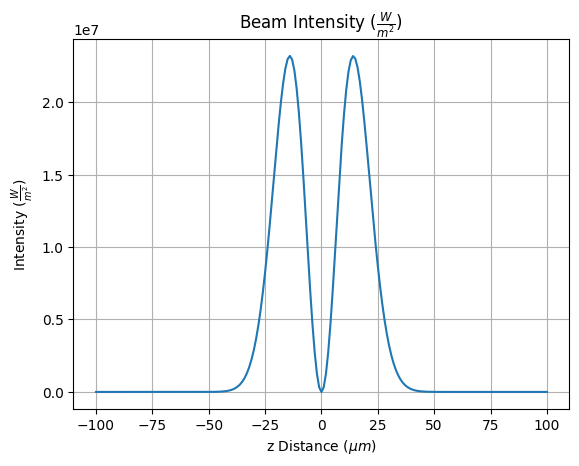

In [12]:
x = np.arange(-100e-6, 100e-6, 1e-6)
y = np.arange(-100e-6, 100e-6, 1e-6)
z = np.arange(-100e-6, 100e-6, 1e-6)

r = [x, y, z]

intensity = field_intensity(r, field_args)

plt.plot(z*1e6, intensity)

plt.xlabel(r'z Distance ($\mu m$)')
plt.ylabel(r"Intensity ($\frac{W}{m^2}$)")
plt.title(r'Beam Intensity ($\frac{W}{m^2}$)')

plt.grid(True)
plt.show()

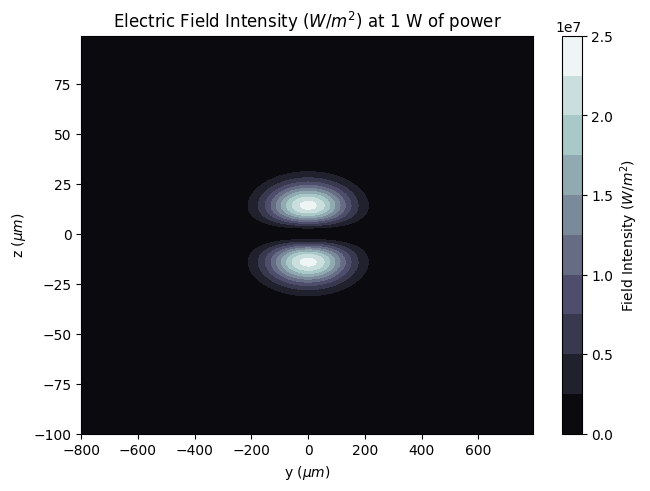

In [13]:
y_label = r"y ($\mu m$)"
z_label = r"z ($\mu m$)"
title = r'Electric Field Intensity ($W/m^2$) at 1 W of power'
color_bar_label = r"Field Intensity ($W/m^2$)"
labels= [y_label, z_label, title, color_bar_label]

plot_contour(fun=field_intensity, ranges=[800, 100], const_val=0, const_coord='x', params=field_args, labels=labels, cmap_color=plt.cm.bone)

# Potentials

## Dipole Potential

### Formula

The general expression for the dipole potential comes from page 6 of [this paper](https://www.uni-ulm.de/fileadmin/website_uni_ulm/nawi.inst.220/lehre/Atomphysik_SS2008/9902072v1.pdf) and is of the form
$$ U_{dip} = \frac{\pi c^2 \Gamma}{2\omega_0^2} \left( \frac{2 + Pg_F m_F}{\Delta_{2,F}} + \frac{1 - Pg_F m_F}{\Delta_{1,F}} \right) I(\vec{r})$$

Where:
- $\Gamma$ is the decay rate of the excited state in rad/s
- $\omega_0$ is the resonant frequency of the transition in m
- $P$ is a coefficient which characterizes the polarization
    - $P = 0$ for linear polarization
    - $P = \pm 1$ for circular polarization

- $g_F$ is the landé g-factor
- $m_F$ is the magnetic quantum number
- $\Delta_{i_f} = \omega - \omega_0$ is the frequency detuning for the D1 or D2 transition
- $I(\vec{r})$ is the intensity as a function of position

For this calculation we will be dealing with linealy polarized light and a laser beam propagating in the x-direction so the expression reduces to:
$$ U_{dip} = \frac{\pi c^2 \Gamma}{2\omega_0^3} \left( \frac{2}{\Delta_{2,F}} + \frac{1}{\Delta_{1,F}} \right) I(y,z)$$

### Code

In [14]:
def dipole_potential(r, *args):
    """
    Function for computing electric dipole potential

    inputs:
        r (list): x,y,z position in m
        args: tuple
            - gamma: D2 decay rate in rad/s
            - lambda_laser: laser wavelength in m
            - lambda_D1: D1 transition frequency in m
            - lambda_D2: D1 transition frequenct in m
            - intensity_args: parameters for field_intensity (see above)
    
    returns: Dipole potential in (Hz) (we just divided the potential by hbar)
    """
    #get parameters
    args=args[0]
    gamma = args[0]

    lambda_laser = args[1]
    lambda_D1 = args[2]
    lambda_D2 = args[3]

    intensity_args = args[4]

    omega = 2*np.pi*Constants.c / lambda_laser
    omega01 = 2*np.pi*Constants.c / lambda_D1
    omega02 = 2*np.pi*Constants.c / lambda_D2

    delta1 = omega - omega01
    delta2 = omega - omega02

    coef = (np.pi * Constants.c**2 * gamma)/(2 * omega02**3)

    intensity = field_intensity(r, intensity_args)

    return (coef * (2/delta2 + 1/delta1) * intensity) / Constants.h

### Plotting

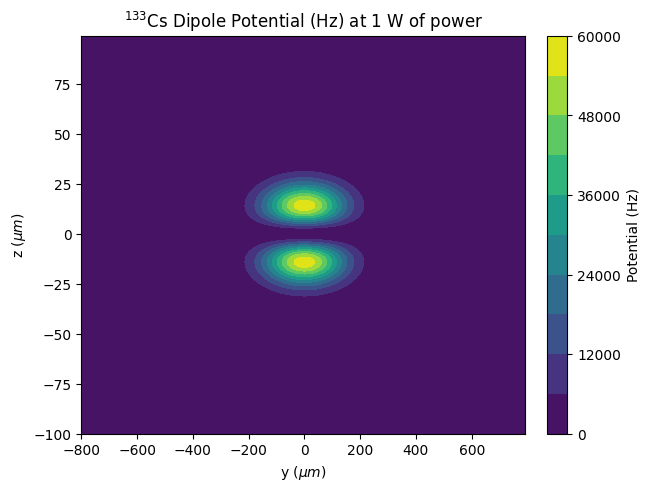

In [15]:
y_label = r"y ($\mu m$)"
z_label = r"z ($\mu m$)"
title = r'$^{133}$Cs Dipole Potential (Hz) at 1 W of power'
color_bar_label = r"Potential (Hz)"
labels= [y_label, z_label, title, color_bar_label]

plot_contour(fun=dipole_potential, ranges=[800, 100], const_val=0, const_coord='x', params=cs_dipole_potential_params, labels=labels, cmap_color=plt.cm.viridis)

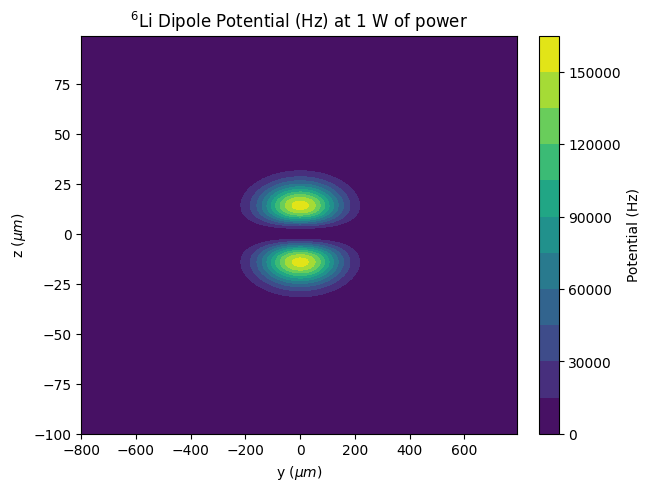

In [16]:
y_label = r"y ($\mu m$)"
z_label = r"z ($\mu m$)"
title = r'$^{6}$Li Dipole Potential (Hz) at 1 W of power'
color_bar_label = r"Potential (Hz)"
labels= [y_label, z_label, title, color_bar_label]

plot_contour(fun=dipole_potential, ranges=[800, 100], const_val=0, const_coord='x', params=li_dipole_potential_params, labels=labels, cmap_color=plt.cm.viridis)

## Magnetic Potential

### Formula

The Bitter coils used in the experiment will also contribute to the total potential experienced by the atoms. Here we assume that the atoms will be at the maximum of the field and that the field itself will be cylindrically symmetric about the z axis due to the orientation of the coils. The magnetic field will approximately be of the form:
$$ B = -\omega_B (x^2 + y^2) + 2\omega_B z^2 $$

Where $\omega_B = 2 \times 10^5$ is the approximate frequency of the magnetic trap used in the experiment

From this, the magnetic potential will be:
$$ U_B = -\frac{\mu_B g_J}{2} \frac{B}{10000} $$

### Code

In [17]:
def magnetic_field(x, y, z):
    """
    Function for calculating the magnetic field intenstity

    inputs:
        x,y,z: position in m
    
    returns: Magnetic field strength in Gauss
    """
    omegaB = 2e5

    return -omegaB * (x**2 + y**2) + 2*omegaB * z**2

In [18]:
def magnetic_potential(r, *args):
    """
    Function for calculating the magnetic field potential for an atom

    inputs:
        - r (list): x,y,z position in m
        - args:
            - g_j: landé g-factor
    
    returns: Magnetic field potential in Hz (we just divide the potential by hbar)

    """
    x = r[0]
    y = r[1]
    z = r[2]
    
    g_j = args[0]

    coef = (Constants.MuB * g_j)/2

    B = magnetic_field(x,y,z)

    return - (coef * B / (1e4)) / Constants.h

In [19]:
### Plotting

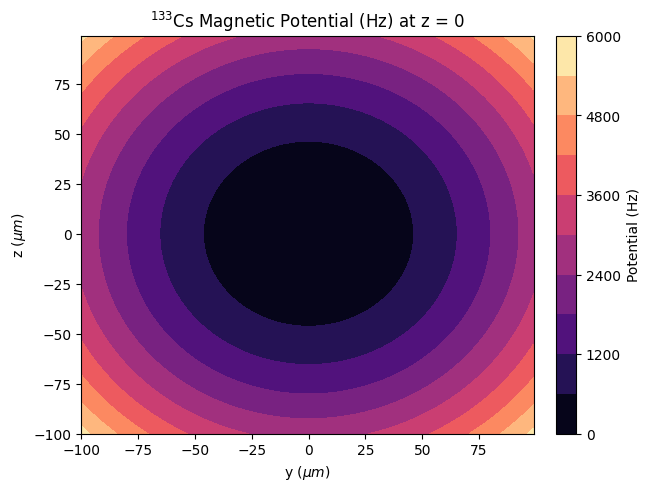

In [20]:
x_label = r"x ($\mu m$)"
y_label = r"y ($\mu m$)"
title = r'$^{133}$Cs Magnetic Potential (Hz) at z = 0'
color_bar_label = r"Potential (Hz)"
labels= [y_label, z_label, title, color_bar_label]

plot_contour(fun=magnetic_potential, ranges=[100, 100], const_val=0, const_coord='z', params=cs_b_potential_params, labels=labels, cmap_color=plt.cm.magma)

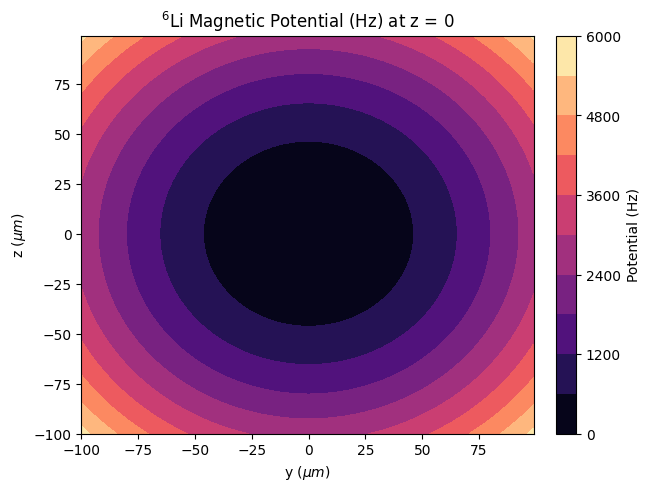

In [21]:
x_label = r"x ($\mu m$)"
y_label = r"y ($\mu m$)"
title = r'$^{6}$Li Magnetic Potential (Hz) at z = 0'
color_bar_label = r"Potential (Hz)"
labels= [y_label, z_label, title, color_bar_label]

plot_contour(fun=magnetic_potential, ranges=[100, 100], const_val=0, const_coord='z', params=li_b_potential_params, labels=labels, cmap_color=plt.cm.magma)

## Gravitational Potential

The gravitational potential is given by the simple formula:
$$ U_{grav} = mgz $$

In [22]:
def grav_potential(z, *args):
    """
    Function for computing the gravitational potential energy of an atom

    inputs:
        - z: height in m
        - args:
            - m: mass in kg
    
    returns: gravitational potential in Hz (we just divide the potential by hbar)
    """
    m = args[0]

    return (m * Constants.g * z) / Constants.h

We can graph this for both atoms

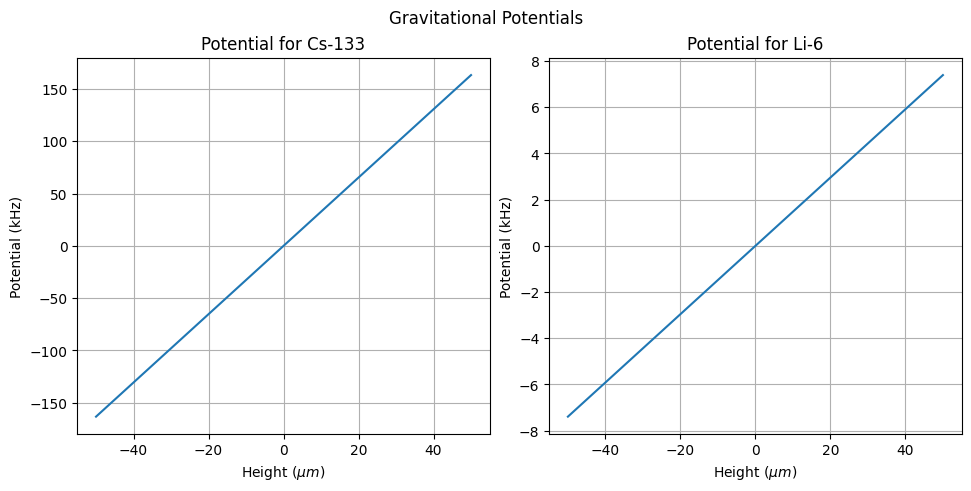

In [23]:
def graph_grav_potential():
    z = np.arange(-50e-6,50e-6, 1e-6)
    fig, ax = plt.subplots(1,2, layout="constrained", figsize=plt.figaspect(0.5))
    fig.suptitle("Gravitational Potentials")

    ax[0].plot(z*1e6, grav_potential(z, (Cs133.mass))*1e-3)
    ax[1].plot(z*1e6, grav_potential(z, (Li6.mass))*1e-3)

    ax[0].set_title("Potential for Cs-133")
    ax[0].set_xlabel(r"Height ($\mu m$)")
    ax[0].set_ylabel("Potential (kHz)")
    ax[0].grid(True)

    ax[1].set_title("Potential for Li-6")
    ax[1].set_xlabel(r"Height ($\mu m$)")
    ax[1].set_ylabel("Potential (kHz)")
    ax[1].grid(True)

graph_grav_potential()
plt.show()

## Total Potential

The total potential will just be the sum of the above three potentials:
$$ U_{tot} = U_{dip} + U_B + U_{grav}  $$

In [24]:
def total_potential(r, *args):
    """
    Function for computing the total potential experienced by an atom

    inputs:
        - x,y,z: position in m
        - args:
            - dipole_params: parameters for dipole potential (see dipole_potential)
            - b_params: parameters for the magnetic field (see magnetic_potential)
            - grav_params: parameters for gravitational potential (see grav_potential)
    
    returns (float): The total potential in Hz
    """
    params = args[0]
    dipole_params = params[0]
    b_params = params[1]
    grav_params = params[2]

    #get z for grav poten
    z = r[2]

    u_dip = dipole_potential(r, dipole_params)

    u_b = magnetic_potential(r, b_params)
    u_grav = grav_potential(z, grav_params)

    return u_dip + u_b + u_grav

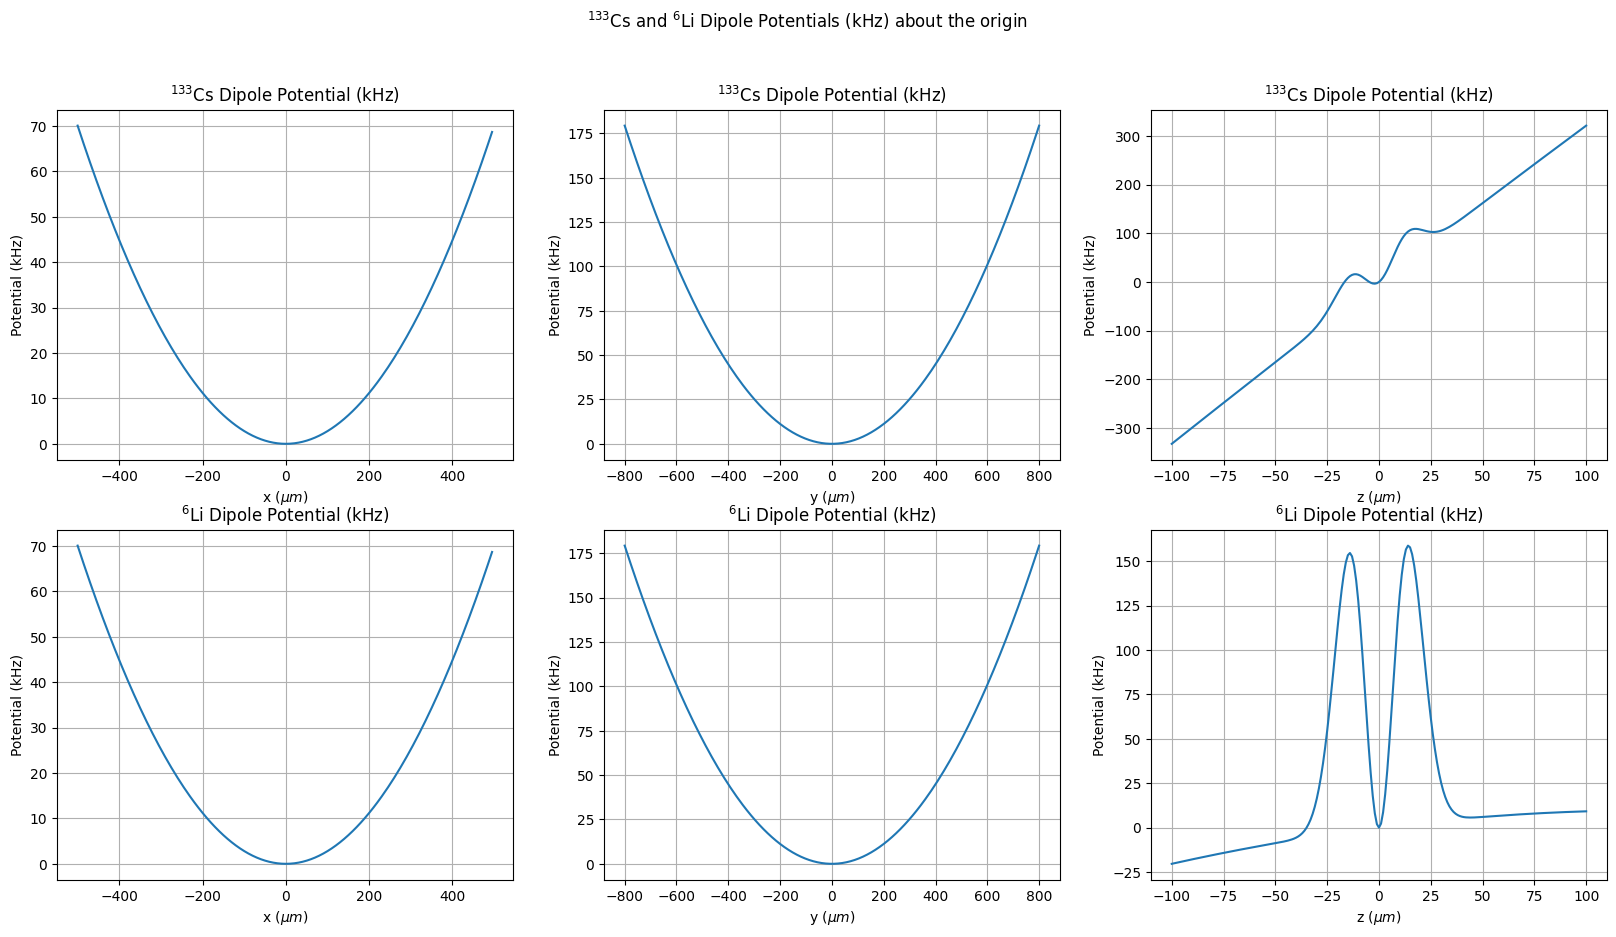

In [82]:
params = (cs_trap_params, li_trap_params)
ranges = [500e-6, 800e-6, 100e-6]
const_vals = [[0, 0, 0], [0,0,0]]

plot_total_potential(poten=total_potential, ranges=ranges, const_vals=const_vals, params=params)

# Trap Calculations

## BEC Stuff

The code here is just copied over from [LiCs-Codebase v2](https://github.com/ChinlabLiCsCode/LiCs-CodebaseV2)

In [138]:
class BEC_calc():
    """
    Class for computing various quantities related to a Cs133 BEC

    Parameters:
        fx: frequency in the x direction (Hz)
        fy: frequency in the y direction (Hz)
        fz: frequency in the z direction (Hz)
        N: the number of atoms?
        a: scattering length (bohr radii)
    
    Returns:
        a_ho: Harmonic Oscillator length (microns)
        muT: chemical potential (nK) #convert to temp by dividing by k_b
        pD: peakDensity
        R_tf: Thomas-Fermi Radii: (Rx, Ry, Rz) (meters)
        xi: Central healing Length (microns)
        TCrit: critical temperature (nK)
        TCor: correction to critical temperature (fraction) caused by finite size and non uniformity
        aCrit: critical scattering length for a spherical potential (m)
        vSound: sound speed (mm/s)
        lambdaDB: Wrong? deBroglie wavelength (microns)
        phaseDensity: Wrong? phase space density # find the formula
    """
    def __init__(self,fx, fy, fz, N, a, printRes=False):
        self.fx=fx
        self.fy=fy
        self.fz=fz
        self.N=N
        self.a=a

        #create a dictionary to store all of the rounded results, if you use the functions, you'll get the exact result
        self.results = dict()

        #convert scattering length to meters
        self.aBr = a *Constants.a0

        #convert frequencies to angluar frequencies
        self.wx = 2*np.pi*fx
        self.wy = 2*np.pi*fy
        self.wz = 2*np.pi*fz

        #compute intermediate values such as the cesium interaction strength, average frequency, and geometric average frequencies
        self.gInt = 4*np.pi*(Constants.HBar**2)*self.aBr / Cs133.mass

        self.w_ho = (self.wx*self.wy*self.wz)**(1/3)

        self.wAvg = np.mean([self.wx, self.wy, self.wz])

        #run all of the calculation functions
        self.a_hoCalc(printVal=False)
        self.muTCalc(printVal=False)
        self.pDCalc(printVal=False)
        self.tfCalc(printVal=False)
        self.xiCalc(printVal=False)
        self.ctCalc(printVal=False)
        self.aCritCalc(printVal=False)
        self.vCalc(printVal=False)
        self.lambdaCalc(printVal=False)
        self.phaseDensityCalc(printVal=False)

        if printRes:
            self.genRes()

    def a_hoCalc(self, printVal:bool):
        "function for computing the harmonic oscillator length, returns value in microns"
        self.a_ho = np.sqrt(Constants.HBar/(Cs133.mass*self.w_ho))
        self.results["Harmonic Oscillator Length (microns)"] = round(self.a_ho * 1e6, 5)

        if printVal:
            return self.a_ho * 1e6

    def muTCalc(self, printVal:bool):
        "function for computing the chemical potential, returns value in nK"
        self.mu = (Constants.HBar*self.w_ho/2)*(15*self.N*self.aBr/self.a_ho)**(2/5)
        self.muT = self.mu / Constants.kB * 1e9 #chemical potential in nK
        self.results["chemical Potential (nK)"] = round(self.muT, 5)

        if printVal:
            return self.muT

    def pDCalc(self, printVal:bool):
        "function for computing peak density"
        self.pD = self.mu/self.gInt
        self.results["Peak Density"] = round(self.pD, 5)

        if printVal:
            return self.pD

    def tfCalc(self, printVal:bool):
        "function for computing the thomas-fermi radius, returns the result in meters"
        rx = np.sqrt( 2*self.mu / (Cs133.mass * (self.wx**2)) )
        ry = np.sqrt( 2*self.mu / (Cs133.mass * (self.wy**2)) )
        rz = np.sqrt( 2*self.mu / (Cs133.mass * (self.wz**2)) )

        R_tf = np.array([rx, ry, rz])
        approxR_tf = np.array([round(rx, 10), round(ry, 10), round(rz, 10)])

        self.results["Thomas-Fermi Radius (m)"] = approxR_tf

        if printVal:
            return R_tf

    def xiCalc(self, printVal:bool):
        "function for computing the central healing length, returns the result in microns"
        xi = (8*np.pi*(self.mu/self.gInt)*self.aBr)**(-1/2)
        self.results["Central healing Length (microns)"] = round(xi*1e6, 5)

        if printVal:
            return xi*1e6

    def ctCalc(self, printVal:bool):
        "function for computing the critical temperature and the corrections, returns the result as an array with the critical temperature (nK), and the total correction as a fraction"
        self.TCrit = 0.94 * Constants.HBar * self.w_ho * self.N**(1/3) / Constants.kB
        self.results["Critical Temperature (nK)"] = round(self.TCrit * 1e9, 5)

        #compute the corrections to the critical temperature
        dT_fsOverTCrit = -0.73 * (self.wAvg/self.w_ho) * self.N**(-1/3) #finite size correction
        dT_ihOverTCrit  = -1.33 * (self.aBr/self.a_ho) * self.N**(1/6) #inhomogenous correction
        TCor = dT_fsOverTCrit + dT_ihOverTCrit
        self.results["Critical Temperature Correction (%)"] = round(TCor, 5)

        if printVal:
            return np.array([self.TCrit*1e9, TCor])

    def aCritCalc(self, printVal:bool):
        "function for computing the critical scattering length, returns the result in meters"
        aCrit = 0.575 * self.a_ho / self.N / Constants.a0
        self.results["Critical Scattering Length (m)"] = round(aCrit, 5)

        if printVal:
            return aCrit

    def vCalc(self, printVal:bool):
        "function for computing the sound speed, returns the result in mm/s"
        vSound = np.sqrt(self.mu/Cs133.mass)
        self.results["sound speed (mm/s)"] = round(vSound *1e3, 5)

        if printVal:
            return vSound*1e3

    def lambdaCalc(self, printVal:bool):
        "function for computing the deBroglie wavelength, returns the result in microns"
        self.lambdaDB = np.sqrt( (2*np.pi*Constants.HBar**2)/(Cs133.mass*self.mu) )
        self.results["deBroglie Wavelength (microns)"] = round(self.lambdaDB * 1e6, 5)

        if printVal:
            return self.lambdaDB * 1e6

    def phaseDensityCalc(self, printVal:bool):
        "function for computing the peak phase space density"
        phaseDensity = self.lambdaDB**3 * (self.mu/self.gInt)
        self.results["Phase space density"] = round(phaseDensity, 5)

        if printVal:
            return phaseDensity

    def genRes(self):
        "Generates results as a pandas data table"
        params = []
        vals = []

        #sort each parameter and value into lists
        for key in self.results:
            params.append(key)
            vals.append(self.results[key])

        #create the dataframe
        df = pd.DataFrame.from_dict({
            "parameter": params,
            "Values":vals
        })

        #display the dataframe
        display(df)

## Fermi Gas Stuff

Same as before, the code is just copied over from [LiCs-Codebase v2](https://github.com/ChinlabLiCsCode/LiCs-CodebaseV2)

In [139]:
class Fermi_calc():
    """
    Class for computing various quantities related to a Li6 Fermi Gas

    Parameters:
        fx: frequency in the x direction (Hz)
        fy: frequency in the y direction (Hz)
        fz: frequency in the z direction (Hz)
        N: the number of atoms?

        liflag: Checks isotope variant
        printRes: checks whether or not to dsiplay results
    
    Returns:
        TF: Fermi Temperature (nK)
        kf: Fermi Momentum
        R_tf: Thomas-Fermi Radii: (Rx, Ry, Rz) (meters)
        pD: peakDensity
        vF: Fermi Velocity (mm/s)
    """
    def __init__(self,fx, fy, fz, N, liflag=False, printRes=False):
        self.fx=fx
        self.fy=fy
        self.fz=fz
        self.N=N

        #create a dictionary to store all of the rounded results, if you use the functions, you'll get the exact result
        self.results = dict()

        #check isotope
        if liflag:
            self.mLi = 40 * Constants.amu 
        else:
            self.mLi = Li6.mass

        #convert frequencies to angluar frequencies
        self.wx = 2*np.pi*fx
        self.wy = 2*np.pi*fy
        self.wz = 2*np.pi*fz

        #compute intermediate values such as the average frequency, and geometric average frequencies
        self.w_ho = (self.wx*self.wy*self.wz)**(1/3)

        self.wAvg = np.mean([self.wx, self.wy, self.wz])

        #run all of the calculation functions
        self.TFCalc(printVal=False)
        self.kfCalc(printVal=False)
        self.R_tfCalc(printVal=False)
        self.pDCalc(printVal=False)
        self.vCalc(printVal=False)

        if printRes:
            self.genRes()

    def TFCalc(self, printVal:bool):
        "function for computing the fermi temperature, returns value in nK"
        self.mu = (Constants.HBar*self.w_ho)*(6*self.N)**(1/3) #fermi energy
        self.TF = self.mu / Constants.kB * 1e9 #convert to fermi temperature  in nK
        self.results["chemical Potential (nK)"] = self.TF

        if printVal:
            return self.TF

    def kfCalc(self, printVal:bool):
        "function for computing the fermi momentum"
        kf = np.sqrt( (2*self.mLi*self.mu) / (Constants.HBar**2))

        self.results["Fermi momentum"] = kf
        self.results["1/Fermi momentum"] = 1/kf

        if printVal:
            return kf

    def R_tfCalc(self, printVal:bool):
        "function for computing the thomas-fermi radius, returns the result in meters"
        self.rx = np.sqrt( 2*self.mu / (self.mLi * (self.wx**2)) )
        self.ry = np.sqrt( 2*self.mu / (self.mLi * (self.wy**2)) )
        self.rz = np.sqrt( 2*self.mu / (self.mLi * (self.wz**2)) )

        R_tf = np.array([self.rx, self.ry, self.rz])
        approxR_tf = np.array([round(self.rx, 10), round(self.ry, 10), round(self.rz, 10)])

        self.results["Thomas-Fermi Radius (m)"] = approxR_tf

        if printVal:
            return R_tf

    def pDCalc(self, printVal:bool):
        "function for computing peak density"
        self.pD = 8/(np.pi**2) * self.N/(self.rx*self.ry*self.rz)
        self.results["Peak Density"] = self.pD

        if printVal:
            return self.pD

    def vCalc(self, printVal:bool):
        "function for computing the sound speed, returns the result in mm/s"
        vSound = np.sqrt(2*self.mu/self.mLi)
        self.results["sound speed (mm/s)"] = vSound *1e3

        if printVal:
            return vSound*1e3

    def genRes(self):
        "Generates results as a pandas data table"
        params = []
        vals = []

        #sort each parameter and value into lists
        for key in self.results:
            params.append(key)
            vals.append(self.results[key])

        #create the dataframe
        df = pd.DataFrame.from_dict({
            "parameter": params,
            "Values":vals
        })
        
        #display the dataframe
        display(df)

## Trap Stuff

In [169]:
class Trap_Calc():
    """
    Class for doing dipole trap calculations and producing plots of the potentials for Lithium and cesium

    inputs:
        - potential (def): function for calculating the potential (Hz)
        - trap_params (list): list of trap parameters for cesium (tuple) and lithium (tuple)
        - NCs: number of cesium atoms
        - NLi: number of lithium atoms
        - plot_ranges: ranges for plotting (see plot_total_potential function)
    
    returns:
        - plot: potentials in x,y,z with min and max marked and chemical potential in z shaded in
        - min (m): location of potential minimums for both species
        - trap depth (kHz): max - min for both species
        - trap frequency (kHz): frequency in x,y, and z for both species
        - chemical potential (kHz): chemical potential for both species
    """
    
    def __init__(self, potential, trap_params, NCs, NLi, plot_ranges):
        #minimize the potential for each species
        cs_min_pos, cs_min_poten, cs_max_pos, cs_max_poten, cs_trap_depth = self.trap_depth_calc(potential, trap_params[0])
        li_min_pos, li_min_poten, li_max_pos, li_max_poten, li_trap_depth = self.trap_depth_calc(potential, trap_params[1])

        #get trap frequency
        cs_fx, cs_fy, cs_fz = self.trap_frequency(potential, trap_params[0], cs_min_pos, Cs133.mass)
        li_fx, li_fy, li_fz = self.trap_frequency(potential, trap_params[1], li_min_pos, Li6.mass)

        #get the chemical potential
        bec_res = BEC_calc(cs_fx, cs_fy, cs_fz, NCs, Cs133.aBB, printRes=False)
        cs_chem_poten_temp = bec_res.results["chemical Potential (nK)"] #in nK
        cs_chem_poten_energy = cs_chem_poten_temp * Constants.kB * 1e-9 #in J
        cs_chem_poten_freq = cs_chem_poten_energy / Constants.h * 1e-3 #in kHz

        fermi_res = Fermi_calc(li_fx, li_fy, li_fz, NLi)
        li_chem_poten_temp = fermi_res.results["chemical Potential (nK)"] # in nK
        li_chem_poten_energy = li_chem_poten_temp * Constants.kB * 1e-9 #in J
        li_chem_poten_freq = li_chem_poten_energy / Constants.h * 1e-3 #in kHz

        #make plots
        cs_trap = [cs_min_poten, cs_max_poten, cs_max_pos]
        li_trap = [li_min_poten, li_max_poten, li_max_pos]
        chem_potentials = [cs_chem_poten_freq, li_chem_poten_freq]
        trap = [cs_trap, li_trap, chem_potentials]
        const_vals = [cs_min_pos, li_min_pos]

        plot_total_potential(poten=total_potential, ranges=plot_ranges, const_vals=const_vals, params=trap_params, trap=trap)
        plt.show()

        #collect results
        results = {
            r'Cs min ($\mu m$)': [round(num*1e6, 5) for num in cs_min_pos],
            'Cs trap depth (kHz)': cs_trap_depth,
            'Cs trap frequency (kHz)': [round(cs_fx/1000, 5), round(cs_fy/1000, 5), round(cs_fz/1000, 5)],
            'Cs chemical potential (kHz)': cs_chem_poten_freq,
            r'Li min ($\mu m$)': [round(num*1e6, 5) for num in li_min_pos],
            'Li trap depth (kHz)': li_trap_depth,
            'Li trap frequency (kHz)': [round(li_fx/1000, 5), round(li_fy/1000, 5), round(li_fz/1000, 5)],
            'Li chemical potential (kHz)': li_chem_poten_freq,
        }

        #generate dataframe for results
        params = []
        vals = []

        #sort each parameter and value into lists
        for key in results:
            params.append(key)
            vals.append(results[key])

        #create the dataframe
        df = pd.DataFrame.from_dict({
            "parameter": params,
            "Values":vals
        })

        #display the dataframe
        display(df)


    def trap_depth_calc(self, potential, trap_params):
        """
        Function for computing the minimum and trap depth of a potential

        inputs:
            - poten_fun (def): trap potential
            - trap_params (tuple): parameters for the trap
        
        returns (list): [min_pos (m), min_poten (kHz), max_pos (m), max_poten (kHz)]

        """
        #define a new objective function and inverse obejective function
        obj_fun = lambda r, args: potential(r*1e-6, args)
        inv_obj_fun = lambda r, args: -potential(r*1e-6, args) #inverse of the potential which we minimize to get the maximum

        bnds = ((-10, 20), (-10, 20), (-15, 20))

        #find min and max
        min_res = sp.optimize.minimize(obj_fun, x0=[0,0,0], bounds=bnds, args=(trap_params,))
        max_res = sp.optimize.minimize(inv_obj_fun, x0=[0,0,-10], bounds=bnds, args=(trap_params,))

        min_pos = min_res['x'] * 1e-6
        max_pos = max_res['x'] * 1e-6

        min_poten = min_res['fun'] * 1e-3
        max_poten = -max_res['fun'] * 1e-3

        trap_depth = max_poten - min_poten

        return [min_pos, min_poten, max_pos, max_poten, trap_depth]


    def trap_frequency(self, potential, trap_params, trap_bottom, mass):
        """
        Function for computing trap frequencies

        Inputs:
            potential_func: function for computing the potential
            trap_params: relevant trap parameters
            trap_bottom: location of the potential minimum (in meters)
            mass: atomic mass in kg

        returns: trap frequency: frequency values in x, y, and z in Hz

        """
        h1 = 1e-6 #step size in meters

        #compute the value of second derivatives in each direction at the trap bottom using both step sizes
        d2udx2 = partial_second_derivative(fun=potential, r=trap_bottom, dir='x', h=h1, params=trap_params)
        d2udy2 = partial_second_derivative(fun=potential, r=trap_bottom, dir='y', h=h1, params=trap_params)
        d2udz2 = partial_second_derivative(fun=potential, r=trap_bottom, dir='z', h=h1, params=trap_params)

        #compute the trap frequency in each direction
        fx = np.sqrt( (d2udx2 * Constants.h) / mass ) / (2 * np.pi)
        fy = np.sqrt( (d2udy2 * Constants.h) / mass ) / (2 * np.pi)
        fz = np.sqrt( (d2udz2 * Constants.h) / mass ) / (2 * np.pi)

        return [fx, fy, fz]

    def optimize_params(self):
        pass

    def return_results(self):
        pass
        #call BEC or Fermi calc functions and collect all results before printing them as a data frame
    

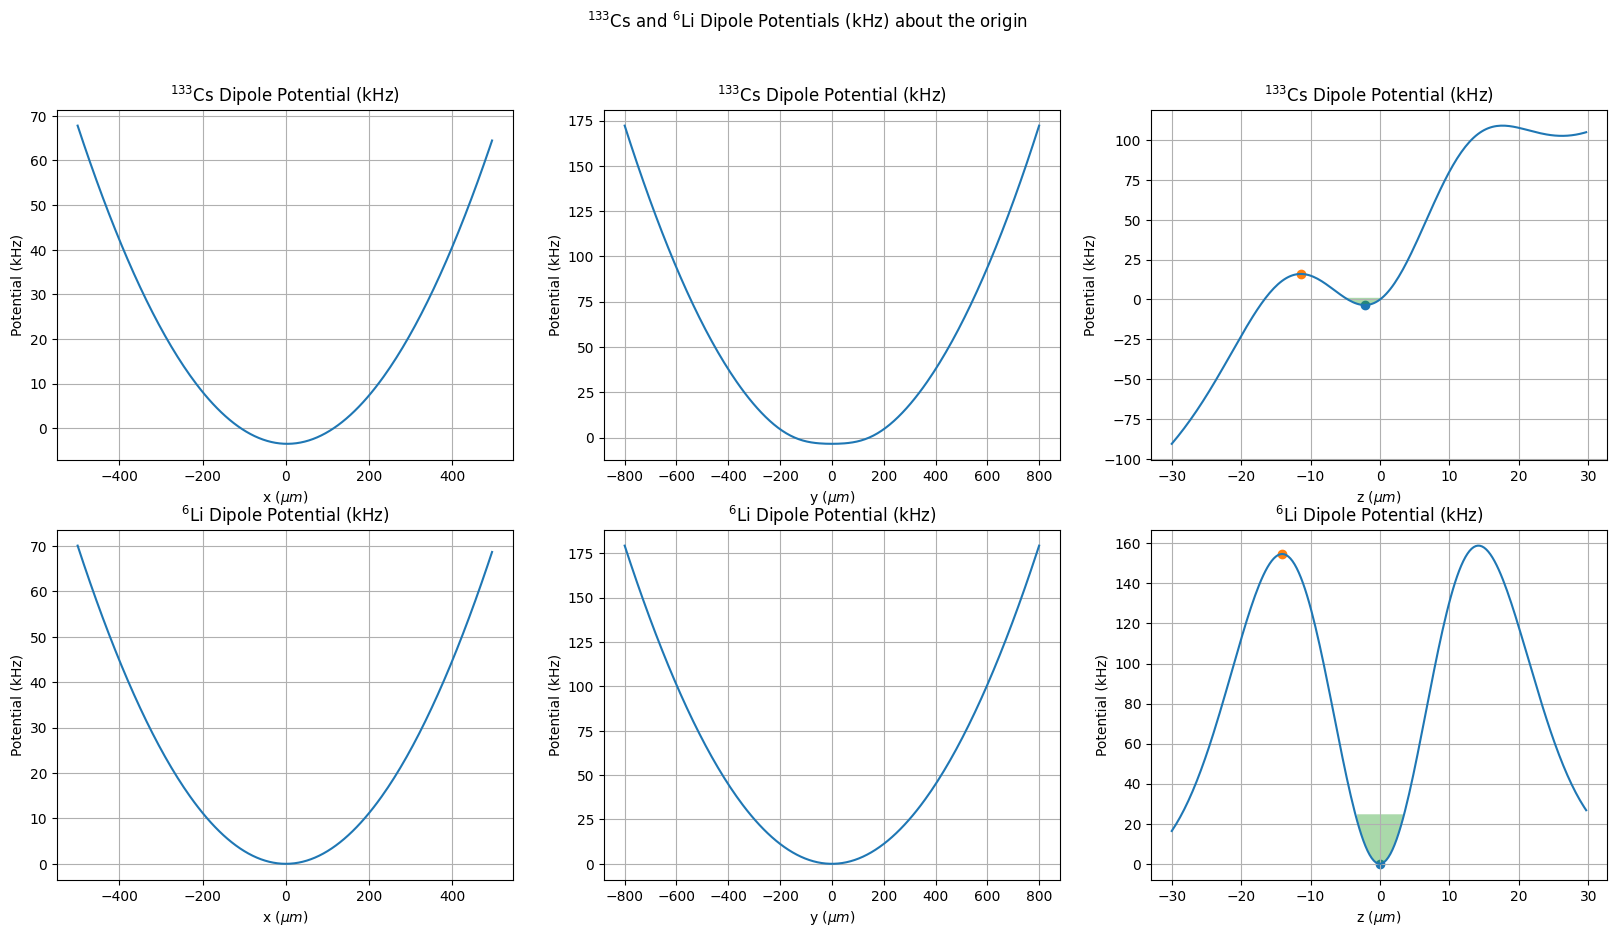

,parameter,Values
0,Cs min ($\mu m$),"[3.24504, -0.0, -2.1839]"
1,Cs trap depth (kHz),19.657853
2,Cs trap frequency (kHz),"[0.00654, 0.00385, 0.32058]"
3,Cs chemical potential (kHz),1.052945
4,Li min ($\mu m$),"[0.00235, 0.0, -0.03467]"
5,Li trap depth (kHz),154.751442
6,Li trap frequency (kHz),"[0.03069, 0.03068, 2.67665]"
7,Li chemical potential (kHz),24.728965


In [178]:
total_trap_params = [cs_trap_params, li_trap_params]
plot_ranges = [500e-6, 800e-6, 30e-6]
NCs = 1e6
NLi = 1e6

trap_calcs = Trap_Calc(total_potential, total_trap_params, NCs, NLi, plot_ranges)